First, I'm going to download **ALL** the packages I need for the rest of the project

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.sparse import csr_array

from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost

**Exploratory Data Analysis**

In [10]:
malpractice = pd.read_csv("medicalMalpractice.csv")

print(malpractice['Amount'].describe())
print(malpractice['Age'].value_counts())
print(malpractice['Gender'].value_counts())
print(malpractice['Insurance'].value_counts())
print(malpractice['Marital Status'].value_counts())
print(malpractice['Private Attorney'].value_counts())
print(malpractice['Severity'].value_counts())
print(malpractice['Specialty'].value_counts())

count     79210.000000
mean     157484.554816
std      193135.093293
min        1576.000000
25%       43670.250000
50%       98131.000000
75%      154675.250000
max      926411.000000
Name: Amount, dtype: float64
Age
43    1439
48    1418
47    1405
50    1395
44    1389
      ... 
84     142
85     134
86     121
1       97
0       89
Name: count, Length: 88, dtype: int64
Gender
Female    47770
Male      31440
Name: count, dtype: int64
Insurance
Private                 34289
Unknown                 24052
Medicare/Medicaid       10882
No Insurance             8002
Workers Compensation     1985
Name: count, dtype: int64
Marital Status
2    41220
1    22802
4    10362
0     3832
3      994
Name: count, dtype: int64
Private Attorney
1    52349
0    26861
Name: count, dtype: int64
Severity
3    28251
4    15709
5     9615
7     8873
9     7755
8     3627
6     3375
2     1340
1      665
Name: count, dtype: int64
Specialty
Family Practice           11436
General Surgery            9412
OBGY

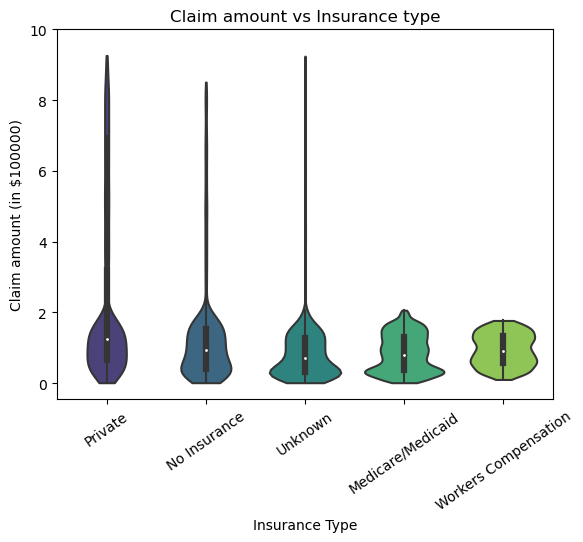

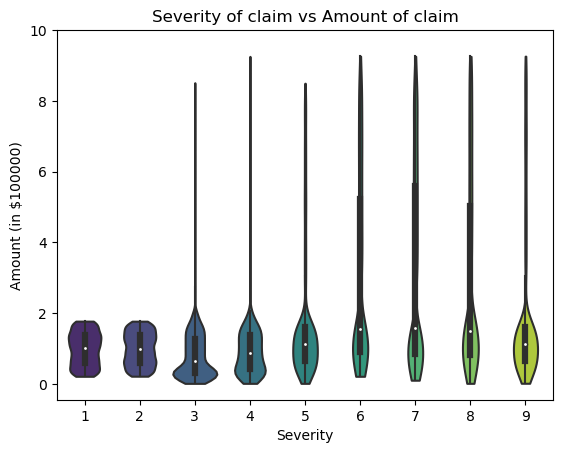

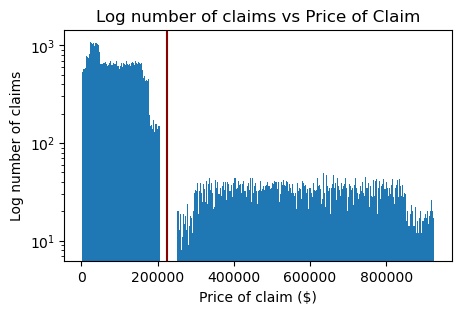

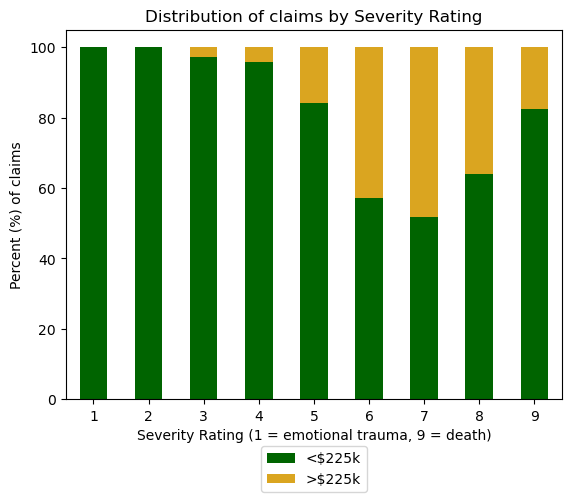

In [11]:
sns.violinplot(data = malpractice, x = "Insurance",y = "Amount", cut =0, palette='viridis')
plt.xticks(rotation = 35)
plt.yticks([0.,  200000.,  400000.,  600000.,  800000.,
        1000000.], [0, 2, 4, 6, 8, 10])
plt.title("Claim amount vs Insurance type")
plt.xlabel("Insurance Type")
plt.ylabel("Claim amount (in $100000)")
plt.show()

sns.violinplot(data = malpractice, x = "Severity", y = "Amount", cut = 0, palette='viridis')
plt.yticks([0.,  200000.,  400000.,  600000.,  800000.,
       1000000.], [0, 2, 4, 6, 8, 10])
plt.title("Severity of claim vs Amount of claim")
plt.ylabel("Amount (in $100000)")
plt.show()

plt.figure(figsize=(5, 3))
plt.hist((malpractice['Amount']), bins = 500, log=True)
plt.title("Log number of claims vs Price of Claim")
plt.xlabel("Price of claim ($)")
plt.ylabel("Log number of claims")
plt.axvline(x = 225000, color = 'darkred', label = 'axvline - full height')
plt.savefig(fname = 'NumClaims.jpeg', dpi = 300)
plt.show()

#Creating a bar plot showing the percent of each severity that has an amount greater than 250k

malpractice['Below225000'] = (malpractice['Amount'] <= 225000)
severity_graph = pd.DataFrame(malpractice.groupby('Severity')['Below225000'].agg('mean'))
severity_graph.reset_index(inplace=True)
severity_graph['Above225000'] = 1 - severity_graph['Below225000']
severity_graph.set_index('Severity',inplace=True)
severity_graph.plot(kind = "bar", stacked=True, color = ['darkgreen', "goldenrod"])
plt.title("Distribution of claims by Severity Rating")
plt.xlabel("Severity Rating (1 = emotional trauma, 9 = death)")
plt.ylabel("Percent (%) of claims")
plt.xticks(rotation = 0)
plt.yticks([0. , 0.2, 0.4, 0.6, 0.8, 1.], [0, 20, 40, 60, 80, 100])
plt.legend(bbox_to_anchor =(0.5,-0.27), loc='lower center', labels = ['<$225k', '>$225k'])
plt.show()

## Notes from EDA

Insurance and Marital Status both have missing values 

Amount is bimodal, with most between 0 and 200k but then some others having suits from 200k to 900k

Two different theoretical projects:
1. Predicting suit price by regression
2. Predicting whether a suit will be for more than 200k by classification

Now, I'll deal with some of the errors I found during EDA:
- Changing marital status and private attorney from numbers to words describing the status
- Changing "unknown" to np.NaN so I can work with missing values

In [12]:
malpractice.loc[malpractice['Insurance'] == "Unknown", "Insurance"] = np.NaN
malpractice.loc[malpractice['Marital Status'] == 0, "Marital Status"] = "Divorced"
malpractice.loc[malpractice['Marital Status'] == 1, "Marital Status"] = "Single"
malpractice.loc[malpractice['Marital Status'] == 2, "Marital Status"] = "Married"
malpractice.loc[malpractice['Marital Status'] == 3, "Marital Status"] = "Widowed"
malpractice.loc[malpractice['Marital Status'] == 4, "Marital Status"] = np.NaN
malpractice.loc[malpractice['Private Attorney'] == 0, "Private Attorney"] = "Not Private"
malpractice.loc[malpractice['Private Attorney'] == 1, "Private Attorney"] = "Private"

print(np.mean(pd.isna(malpractice['Marital Status'])))
print(np.mean(pd.isna(malpractice['Insurance'])))
print(malpractice.isnull().any(axis = 'columns').mean())

X = malpractice.drop(columns=['Amount', 'Below225000'])
y = malpractice['Amount'].copy()
y[y <= 250000] = 0
y[y > 250000] = 1

0.13081681605857845
0.3036485292261078
0.3787779320792829


Creating the transformer to place into a pipeline

In [13]:
one_hot_fts = ['Private Attorney', 'Marital Status', 'Specialty', 'Insurance', 'Gender']

std_fts = ['Age']

preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(), one_hot_fts), 
        ('std', StandardScaler(), std_fts)])

The following code is the meat of the operation. It takes in X, y, a model, a dictionary of hyperparameters, and whether to impute data or not. It then returns a list of the best test scores

In [191]:
def StratModelCreator(X, y, model, param_dict: dict, impute = False, n_states = 4, tree = False):
    #the following code makes it so I don't have to append model__ before every hyperparameter
    model_name = model.__class__.__name__
    param_dict = {f"{model_name.lower()}__{key}": value for key, value in param_dict.items()}

    test_scores = []
    for state in np.linspace(0, n_states - 1, n_states, dtype = int):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)    
        cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=state)
        if impute:
            imputer = IterativeImputer(random_state=state)
            #this is necessary because the preprocessor throws out a sparse SciPy matrix, which IterativeImputer can't take
            dense = FunctionTransformer(csr_array.toarray, accept_sparse=True)
            pipeline = make_pipeline(preprocessor, dense, imputer, model)
        else:
            pipeline = make_pipeline(preprocessor, model)
        
        #grid = GridSearchCV(pipeline, param_grid = param_dict, scoring = 'f1', cv = cv, verbose = 1, n_jobs=-3, error_score='raise')

        grid = RandomizedSearchCV(pipeline, param_dict, n_iter = 150,
                        scoring = 'f1', cv = cv, verbose = 1, n_jobs=-3)
        grid.fit(X_train, y_train)
        y_preds = grid.predict(X_test)
        test_scores.append(accuracy_score(y_test, y_preds))    
        
        #In the final model run-through, use Shap Explainers to get global feature importance
        if state == 0:
            preprocessor.fit(X_train)
            transformed_test = shap.sample(preprocessor.transform(X_test).toarray(), 500, random_state=state)

            #tree models can use the TreeExplainer SHAP, but other models just use the regular SHAP
            if tree:
                explainer = shap.Explainer(grid.best_estimator_[-1])
            else:
                explainer = shap.Explainer(lambda x: grid.best_estimator_[-1].predict_proba(x)[:, 1], transformed_test)
            
            shap_values = explainer.shap_values(transformed_test)
            shap.summary_plot(shap_values, pd.DataFrame(transformed_test, columns=preprocessor.get_feature_names_out()), plot_type="bar", 
                            max_display = 6, show = False)
            plt.title(f"Most important features in the {model_name} model")
            plt.xlabel("Average impact on model prediction")
            plt.savefig(f"{model_name}shap.png", dpi = 300)
            plt.show()    
            
            conf = confusion_matrix(y_test, y_preds, normalize='true')
            display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = ['Small suit', 'Large suit'])
            display.plot()
            plt.title(f"Confusion Matrix for {model_name}")
            plt.savefig(f"{model_name}confmatrix.png", dpi = 300)
            plt.show()
            
            
            
    return test_scores

In [ ]:
#--LogisticRegression
logreg_param_dict = {
    'penalty': ['elasticnet'], 
    'C': np.logspace(-3, 3, 5), 
    'l1_ratio': np.linspace(0.1, 0.9, 5)
}

logreg = LogisticRegression(max_iter = 750, solver = 'saga')
logreg_scores = StratModelCreator(X, y, logreg, param_dict=logreg_param_dict, impute=True, tree=False)


#--- K-nearest neighbors
knn_dict = {
    'n_neighbors': np.linspace(10, 50, 10, dtype=int),
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
knn_scores = StratModelCreator(X, y, knn, param_dict=knn_dict, impute = True, tree = False)


#-- XGBoost
#list of parameters to loop through for XGBoost
xgb_param_dict = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': np.linspace(3, 12, 3, dtype=int),
    'n_estimators': [25, 50, 75],
    'gamma': [0.01, 0.05, 0.1, 0.2], 
    'reg_alpha': [0.01, 0.1, 1, 10], 
    'reg_lambda': [0.01, 0.1, 1, 10]
}

xgb = xgboost.XGBClassifier()
xgb_scores = StratModelCreator(X, y, xgb, param_dict=xgb_param_dict)



Creating a graph to analyze age's effect on the size of a claim

In [ ]:
sns.violinplot(data = malpractice, x = "Below225000", y = "Age", cut = 0, palette='viridis')
plt.title("Age of person vs size of claim")
plt.ylabel("Age of claimant")
plt.xticks([True, False], ['Small Claim', 'Large Claim'])
plt.xlabel("Size of claim")
plt.savefig("AgeGraph.png", dpi = 300)
plt.show()


Final data results

Text(0, 0.5, 'Accuracy score')

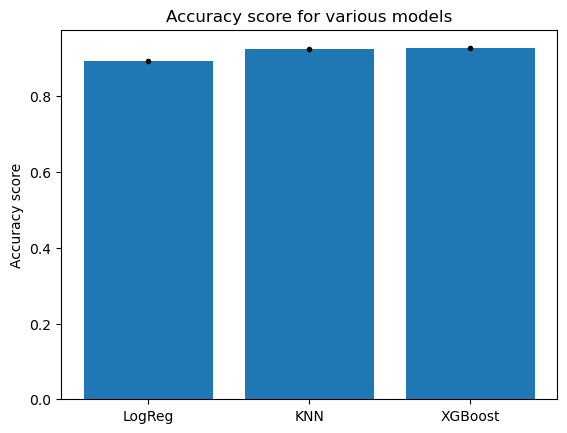

In [234]:
logreg_test = [0.8926271935361697, 0.890922863274839, 0.8926271935361697, 0.8935740436813534]
logreg_best_estimator = LogisticRegression(C=63.0957344480193, l1_ratio=0.0,
                                    max_iter=1000, penalty='elasticnet',
                                    solver='saga')

knn_test = [0.921222067920717, 0.9261456886756723, 0.9250094685014518, 0.925325085216513]
knn_best_estimator = KNeighborsClassifier(n_neighbors=27, weights='uniform')

xgb_test = [0.927092538820856, 0.9289231157682111, 0.9286074990531499, 0.9291124857972478]
xgb_best_estimator = xgboost.XGBClassifier(gamma=0.01, learning_rate=0.1,
                               max_depth=12, n_estimators=75)

means = [np.mean(logreg_test), np.mean(knn_test), np.mean(xgb_test)]
errors = np.multiply((1.965 / np.sqrt(2)), [np.std(logreg_test), np.std(knn_test), np.std(xgb_test)])

plt.bar(["LogReg", "KNN", "XGBoost"], means)
plt.errorbar(["LogReg", "KNN", "XGBoost"], means, yerr=errors, fmt = ".", color = "black", elinewidth=2,capthick=10,errorevery=1)
plt.title("Accuracy score for various models")
plt.ylabel("Accuracy score")
